# Two-Fluids SBN topological

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from scipy import *
from numpy import *
from pylab import *
import arrayfire as af
from core_libs.bindings import *
from core_libs.af_loader import *
from core_libs.functions_for_initial_conditions import *
from core_libs.functions_for_fit import *
from core_libs.turbulence_methods import *
from scipy import fftpack
from scipy import special
from matplotlib.pyplot import *
from scipy import optimize
import scipy as sp
from IPython.display import Markdown, display
from scipy.special import jv, jn
import enlighten

import warnings
warnings.filterwarnings('ignore')


def printmd(string, color=None):
    colorstr = "#### <span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

# <font color='green'>System parameters - configuration</font>

#### <span style='color:green'>$P_{fluid}=$48.8$\mu W$</span>

#### <span style='color:red'>$P_{obs}=$41.97562358276644$\mu W$</span>

#### <span style='color:blue'>$c_s=$0.0091</span>

#### <span style='color:blue'>$v=$0.003</span>

#### <span style='color:blue'>$v/c_s=$0.3321</span>

#### <span style='color:blue'>$\xi=$3.94$\mu m$</span>

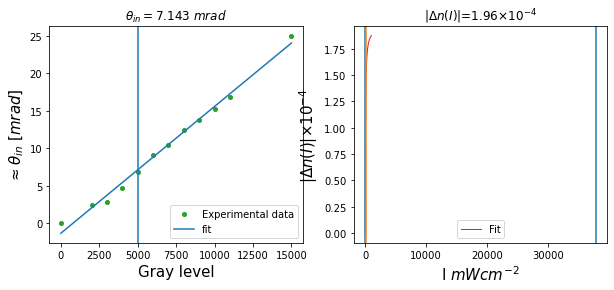

In [3]:
#%matplotlib widget
%matplotlib inline

R = ((2.36-1)/(2.36+1))**2.0
T = 1 - R

#########################################################################################################
#Velocity of the fluid
GL = 5000

#Scaling factor of the power meter
power_meter_factor = 1.34+1.6*0

d_lattice = 30e-4


P_green_beam = 48.8 #muW
P_green_beam_corrected = power_meter_factor*P_green_beam
w = 0.32*d_lattice #cm

#Red beam parameters
P_red_beam = 50.2 #muW
d_bessel = 121.6e-4 #cm

#########################################################################################################

P_green_beam_corrected *= T
P_red_beam *= T




I_fluid = P_green_beam_corrected*1e-3*2/(np.pi*w**2.0)

r_bessel = d_bessel/2.0
I_defect = P_red_beam*1e-3/(np.pi*r_bessel**2.0)

fig = plt.figure(figsize=(10, 4))

rows = 1
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])

GL_to_load = [0, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 15000]
angle = [0, 0.00244017, 0.00280785, 0.00476556, 0.00679314, 0.0090616, 0.01050736, 0.01238871, 0.013732, 0.01519613, 0.01677856, 0.02503264]


popt_x_ve, pcov_x = sp.optimize.curve_fit(linear_fit, GL_to_load, angle, p0=[0.001, 0.0])

plt.title("$\\theta_{in}=$" + str(np.round(linear_fit(np.array(GL), *popt_x_ve)/(1e-3),3)) + " $mrad$")
plt.plot(GL_to_load, np.array(angle)/(1e-3), linewidth=0, marker="o", markersize=4, color="tab:green", label="Experimental data")
plt.plot(GL_to_load, linear_fit(np.array(GL_to_load), *popt_x_ve)/(1e-3), label="fit")
plt.xlabel("Gray level", fontsize=15)
plt.ylabel("$\\approx\\theta_{in}$ $[mrad]$", fontsize=15)
plt.axvline(x=GL)

plt.legend(loc=0)   

plt.subplot(grid[0, 1])

N_rings_level_2 = [0, 1, 1, 2, 4, 6, 6, 7, 7]
max_or_minimum_level_2 = [1, 0, 1, 1, 0, 0, 1, 1, 1]

delta_phi_level_2 = np.zeros(len(N_rings_level_2))

for i in range(len(delta_phi_level_2)):
    if max_or_minimum_level_2[i]==1:
        delta_phi_level_2[i] = 2.0*N_rings_level_2[i]*np.pi
    else:
        delta_phi_level_2[i] = 2.0*(N_rings_level_2[i]-1)*np.pi
        
k0 = 2.0*np.pi/(532e-9) 
L = 20e-3
delta_n_level_2 = delta_phi_level_2/(k0*L)

power_to_load_level_2 = [0.553, 2.02, 5.86, 12.72, 29.6, 78.1, 192, 512, 961]
intensities_level_2 = 2.0*np.array(power_to_load_level_2)*power_meter_factor*1e-3/(np.pi*(0.0245)**2.0)

intensities_level_2 *= T

delta_n_params, pcov_x = sp.optimize.curve_fit(delta_n_f, intensities_level_2, delta_n_level_2, p0=[1e-4,25])



plt.title("|$\Delta n(I)$|=" + str(np.round(delta_n_f(I_fluid, *delta_n_params)/(1e-4),3)) + "$\\times 10^{-4}$")

I_theo = np.linspace(0, 1000)
plt.plot(I_theo, delta_n_f(I_theo, *delta_n_params)/1e-4, linewidth=1, label='Fit', color="tab:red")
plt.axvline(x=I_fluid)
plt.axvline(x=70.840/2)
plt.axvline(x=delta_n_params[-1], color="tab:orange")
plt.xlabel("I $mWcm^{-2}$", fontsize=15)
plt.ylabel("|$\Delta n(I)$|$\\times 10^{-4}$", fontsize=15)
plt.legend(loc=0)

plt.tight_layout()

ne = 2.36
k0 = 2.0*np.pi/(532e-9)
cs = np.sqrt(delta_n_f(I_fluid, *delta_n_params)/ne)
fluid_velocity = linear_fit(np.array(GL), *popt_x_ve)/ne
healing_length = 1.0/(ne*k0*cs)

printmd("$P_{fluid}=$" + str(P_green_beam) + "$\mu W$", color="green")
printmd("$P_{obs}=$" + str(P_red_beam) + "$\mu W$", color="red")

printmd("$c_s=$" + str(np.round(cs,4)), color="blue")
printmd("$v=$" + str(np.round(fluid_velocity,4)), color="blue")
printmd("$v/c_s=$" + str(np.round(fluid_velocity/cs,4)), color="blue")

printmd("$\\xi=$" + str(np.round(healing_length/(1e-6),2)) + "$\\mu m$", color="blue")

# <font color='green'>Calculate simulation parameters</font>

In [4]:
#simulation beam power
If1 = I_fluid/I_fluid #mw/cm^-2 fluid beam
If2 = I_defect/I_fluid #mw/cm^-2 defect
Isat = delta_n_params[-1]/I_fluid #mw/cm^-2

#light fluid wavelength
lf=532*10**-9

#k_fluid
kf = (2*pi)/lf

#parameters of the crystal
ne = 2.36 #index of refraction n_e
r33 = 235*10**-12 #pm/V
#Biasing electric Field
E0 = 1400*10**2 # V/m

#maximum index variation
#delta_n_max = 0.5*ne**3*r33*E0
delta_n_max = delta_n_params[0]
delta_n = delta_n_f(I_fluid, *delta_n_params)


#absorption
alpha = 100 /(delta_n_max * kf) #1.319 cm^-2
gamma = 1

#healing length
hl = 1/(kf*sqrt(ne*delta_n))

#transverse direction scaling factor
factor_t = kf*sqrt(ne*delta_n_max)

#propagation direction scaling factor
factor_z = kf*delta_n_max


##################################################
#Crystal Size
lx = 0.5*10**-3
ly = 0.5*10**-3
lz = 20*10**-3

#in adimensional units
lx_sim = factor_t*lx
ly_sim = factor_t*ly
lz_sim = factor_z*lz

##################################################


Vmax = -1.0*10**-4/delta_n
vel_max = 1/(sqrt(ne)*sqrt(delta_n))

print("I_fluid -> " + str(I_fluid))
print("I_obs -> " + str(I_defect))
print("I_sat -> " + str(Isat*I_fluid))
print("delta_n -> " + str(delta_n))
print("delta_n_max -> " + str(delta_n_max))
print("lx -> " + str(lx_sim))
print("ly -> " + str(ly_sim))
print("lz -> " + str(lz_sim))
print("V_max -> "+ str(Vmax))
print('vel_max - > ' + str(vel_max))
print('healing length - > ' + str(hl))

I_fluid -> 37770.75941336175
I_obs -> 361.4432556354966
I_sat -> 47.01351228990546
delta_n -> 0.00019599457868330083
delta_n_max -> 0.00019623853442252335
lx -> 127.08268668041964
ly -> 127.08268668041964
lz -> 46.35349910473888
V_max -> -0.5102181941551847
vel_max - > 46.496682684440636
healing length - > 3.936894103673364e-06


# <font color='green'>Create simulation mesh</font>

Define the simulation box parameters

In [6]:
#number of transversal dimensions (only working 1 and 2, necessary for plotting)
dims = 2

#Number of points in x,y transversal dimensions
Nx = 512
Ny = 512

#do not change Nt, Nz
Nt = 1 
Nz = 1

#spatial steps
dx = lx_sim / Nx
dy = ly_sim / Ny
dt = 1.
print('dx->',dx,'dy->',dy)

#integration parameters

stride = 50
dz = 0.05 #.2
total_steps = int(lz_sim/(stride*dz))
print(total_steps)

#define a directory to save
saveDir = r".topological_tests"

dx-> 0.2482083724226946 dy-> 0.2482083724226946
18


# <font color='green'>Create simulation initial conditions</font>

In [128]:
def gaussian_distribution(x_af, y_af, defect_power, defect_intensity_normalization, 
                          xi, xf, yi, yf, Nx, Ny, w, factor_t):
   
    x_centers = np.linspace(xi, xf, Nx)
    y_centers = np.linspace(yi, yf, Ny)
    
    np_array = 0
    
    for i in range(0,len(x_centers)):
        for j in range(0,len(y_centers)):
            x_i=x_centers[i] + (int(j/3)%2)*5  + 0.5*(2*np.random.rand()-1)
            y_i = y_centers[j] 
            np_array += np.exp(-( (x_af - x_i)**2.0 + (y_af - y_i)**2.0 ) / w**2.0)
    
    
    
    d_x = (x_af[1,0]-x_af[0,0])
    d_y = (y_af[0,1]-y_af[0,0])
    
    
    norm = np.sum(np.abs(np_array)**2.0)*d_x*d_y/factor_t/factor_t*1e4
    
    I_defect = defect_power/norm
    
    I_defect_normalized = I_defect/defect_intensity_normalization
    
    return af.to_array(np.sqrt(I_defect_normalized)*np_array)

In [129]:
N_gaussians = int(lx_sim/(d_lattice*1e-2*factor_t))
print(N_gaussians)

16


In [140]:
#Simulation parameters

waist_sim = w*1e-2*factor_t

#dd = 115.3*10**-6*factor_t #bessel
#dd2 = 239*10**-6*factor_t #bessel

dd = d_bessel*1e-2*factor_t/2.0

#cs = np.sqrt(1/Isat)
theta = fluid_velocity*ne
vx = theta/ne/np.sqrt(ne*delta_n)
cs = np.sqrt(delta_n/ne)
gamma = 1

N_gaussians = int(lx_sim/(d_lattice*1e-2*factor_t))

print(N_gaussians)

print("vx = " + str(vx))
print("vx/cs = " + str(theta/ne/cs))
print("bessel diameter = " + str(dd))

my_simulation = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                  stride,dx,dy,dz,dt,0,0, 
                                  alpha, Isat, gamma, saveDir)

#Gaussian field - fluid
my_simulation.initial_condition.add_field(0*gaussian_2d_field(my_simulation.x_af, 
                                                            my_simulation.y_af,
                                                            np.sqrt(If1),
                                                            waist_sim, 
                                                            Nx*dx/2,
                                                            Ny*dy/2,
                                                            0*vx,
                                                            0))

#Noise
#my_simulation.initial_condition.add_field(whitenoise_2d_field(my_simulation.x_af, 0.2))

#Axicon - optical defect

my_simulation.initial_condition2.add_field(gaussian_distribution(my_simulation.x_af,
                                                                 my_simulation.y_af, 
                                                                 70.3*1e-3,
                                                                 delta_n_params[-1],
                                                                 0,
                                                                 lx_sim,
                                                                 0,
                                                                 ly_sim,
                                                                 N_gaussians, 
                                                                 N_gaussians,
                                                                 waist_sim,
                                                                 factor_t))


my_simulation.initial_condition2.add_field(whitenoise_2d_field(my_simulation.x_af, 0.0))

#how many
number_nl_numbers = 0
#(g, power)
nl_numbers = []
my_simulation.number_nl_numbers = number_nl_numbers

#define the nonlinearities of type vector
#how many
number_nl_vectors = 0
nl_vectors=[]
my_simulation.number_nl_vectors = number_nl_vectors

16
vx = 0.14072654618235206
vx/cs = 0.3321146489903508
bessel diameter = 15.453254700339029


In [141]:
input_beam_profile = np.transpose(np.abs(my_simulation.initial_condition.np_array)**2.0)
print("P_measured: ", P_green_beam_corrected)
print("P_numerical: ", np.sum(input_beam_profile)*dx*dy/factor_t/factor_t*1e4*I_fluid/(1e-3))
print("\n")
input_axicon_size = np.transpose(np.abs(my_simulation.initial_condition2.np_array)**2.0)
print("P_measured: ", P_red_beam)
print("P_numerical: ", np.sum(input_axicon_size)*dx*dy/factor_t/factor_t*1e4*delta_n_params[-1]*1e3)
print("\n")
print(I_fluid)
print(Isat)

P_measured:  54.67868480725623
P_numerical:  0.0


P_measured:  41.97562358276644
P_numerical:  70.29999999999997


37770.75941336175
0.0012447065671990169


# <font color='Green'>Test simulation initial conditions</font>

Text(0, 0.5, '$y$ $(mm)$')

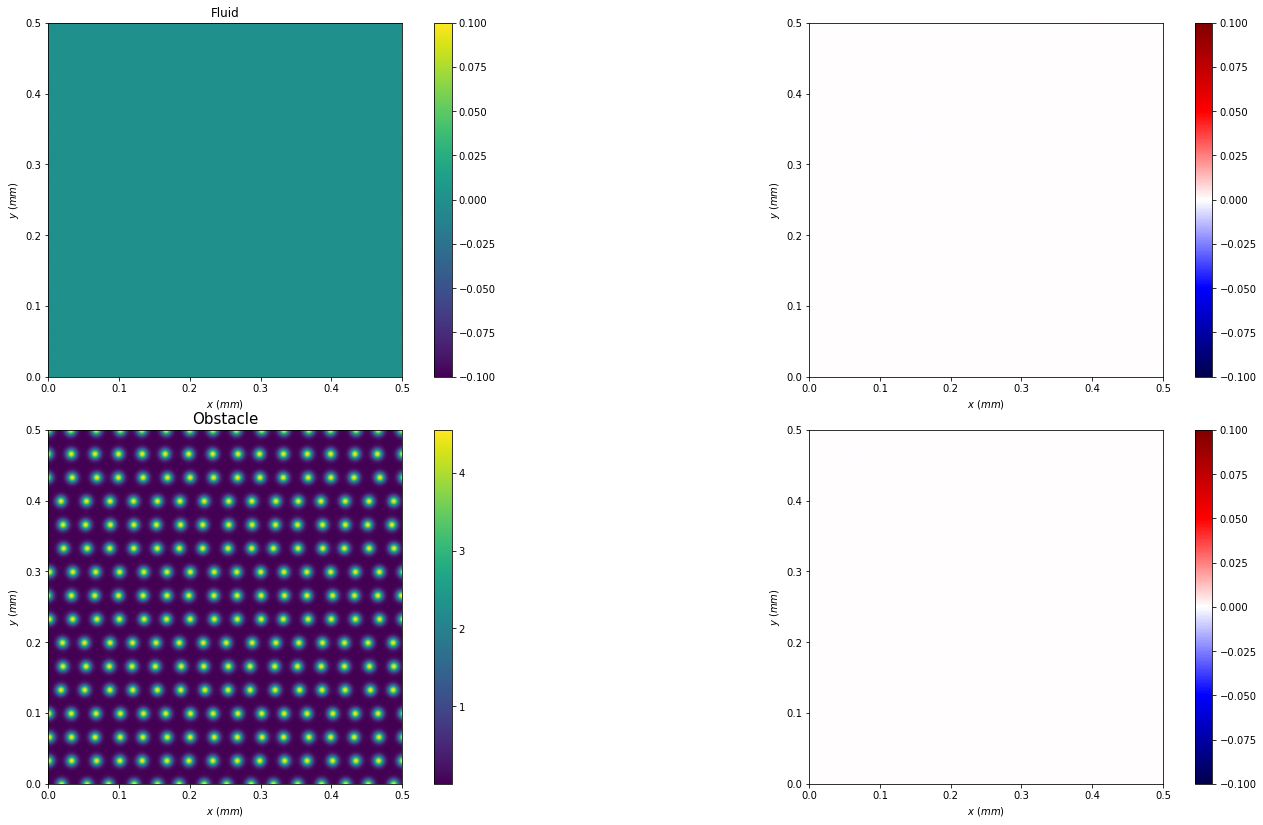

In [142]:
#%matplotlib widget
%matplotlib inline

######################### Gausian

extent_general = [0, Nx*dx/factor_t/(1e-3), 0, Ny*dy/factor_t/(1e-3)]

input_beam_profile = np.transpose(np.abs(my_simulation.initial_condition.np_array)**2.0)
phase_input_beam = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition.np_array), np.real(my_simulation.initial_condition.np_array)))


fig = plt.figure(figsize=(25, 14))

rows = 2
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

plt.subplot(grid[0, 0])
plt.title("Fluid")
plt.imshow(input_beam_profile, extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[0, 1])
plt.imshow(phase_input_beam, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")



#######################          Axicon
input_axicon_size = np.transpose(np.abs(my_simulation.initial_condition2.np_array)**2.0)
phase_axicon = np.transpose(np.arctan2(np.imag(my_simulation.initial_condition2.np_array), np.real(my_simulation.initial_condition2.np_array)))

axicon_max = np.max(input_axicon_size)


######################################################################################################################################################

plt.subplot(grid[1, 0])
plt.title("Obstacle", fontsize=15)
plt.imshow(input_axicon_size, extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")

plt.subplot(grid[1, 1])

plt.imshow(phase_axicon, cmap="seismic", extent=extent_general)
plt.colorbar()
plt.xlabel(r"$x$ $(mm)$")
plt.ylabel(r"$y$ $(mm)$")


# <font color='green'>Generate Configuration file</font>

In [143]:
my_simulation.gen_config_file(nl_numbers,nl_vectors)

**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!


# <font color='green'>Set device to compute</font>

In [144]:
af.device.set_device(0)
af.device.device_info()

{'device': 'GeForce_GTX_TITAN',
 'backend': 'OpenCL',
 'toolkit': 'NVIDIA CUDA',
 'compute': '1.2'}

# <font color='green'>Run Simulation</font>

Having the engine built previously and added to the folder we can call from the command line to execute it.

Options:

First argument corresponds to backend: 1 - CPU; 2 - OpenCl; 3 - CUDA;

Second argument corresponds to device: 0 - #number of devices available to choose the device

In [145]:
%%cmd
hibpm_run.exe 2 0 

Microsoft Windows [Version 10.0.19044.1706]
(c) Microsoft Corporation. All rights reserved.

(LAB_env) E:\Nonlinear_Optics_LAB\LAB_Repository\Tiago_Code\SBN>hibpm_run.exe 2 0 
Running info
Creating a mesh for our problem 
---Mesh created--- 
---scalar field created--- 
---start--- 
Stride 0 of 18 aqui:0.05
aqui
update Stride 1 of 18 aqui:0.05
aqui
update Stride 2 of 18 aqui:0.05
aqui
update Stride 3 of 18 aqui:0.05
aqui
update Stride 4 of 18 aqui:0.05
aqui
update Stride 5 of 18 aqui:0.05
aqui
update Stride 6 of 18 aqui:0.05
aqui
update Stride 7 of 18 aqui:0.05
aqui
update Stride 8 of 18 aqui:0.05
aqui
update Stride 9 of 18 aqui:0.05
aqui
update Stride 10 of 18 aqui:0.05
aqui
update Stride 11 of 18 aqui:0.05
aqui
update Stride 12 of 18 aqui:0.05
aqui
update Stride 13 of 18 aqui:0.05
aqui
update Stride 14 of 18 aqui:0.05
aqui
update Stride 15 of 18 aqui:0.05
aqui
update Stride 16 of 18 aqui:0.05
aqui
update Stride 17 of 18 aqui:0.05
aqui
update Total elapsed time 	5127
ArrayFire v3.6.4 (

# <font color='green'>Load data</font>

In [146]:
#load the simulation mesh - here we use the data generated , deprecating the previous generated data; 
#they are equivalent, but this way you can adapt the same codes to simulations generated from pure c++ simulations

#load the simulation mesh
my_mesh = mesh(saveDir+"/")

#load the data from data folder
#stride between consecutive loaded files
stride_read = 1

simulation_data,zs = load_data_folder(saveDir+"/gnlse_field/",my_mesh,stride_read)
simulation_data2,zs = load_data_folder(saveDir+"/gnlse_field2/",my_mesh,stride_read)

# <font color='green'>Plot results</font>

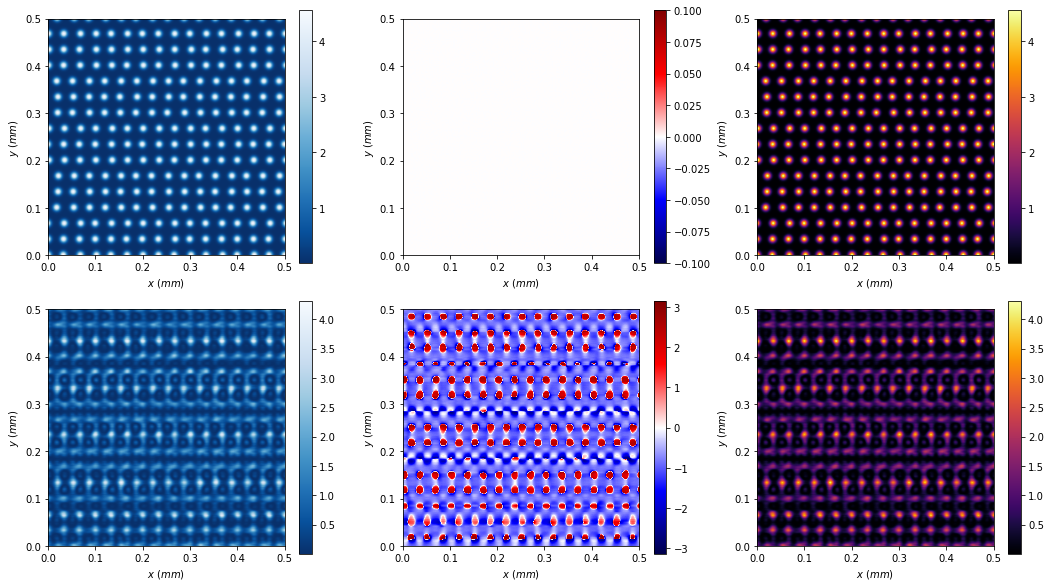

In [147]:
#%matplotlib widget
%matplotlib inline

fig = plt.figure(figsize=(18, 10))

rows = 2
columns = 3

grid = plt.GridSpec(rows, columns, wspace = .2, hspace = .15)

extent_general = [0, my_mesh.lx/factor_t/(1e-3),0,my_mesh.ly/factor_t/(1e-3)]

plt.subplot(grid[0, 0])

im = imshow(transpose(abs(simulation_data2[0])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[0, 1])
phase = np.arctan2(np.imag(simulation_data2[0]), np.real(simulation_data2[0]))
im = imshow(transpose(phase), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[0, 2])
im1 = imshow(transpose(abs(simulation_data2[0])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = cm.inferno)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im1)

plt.subplot(grid[1, 0])
im = imshow(transpose(abs(simulation_data2[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = 'Blues_r')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[1, 1])
phase = np.arctan2(np.imag(simulation_data2[-1]), np.real(simulation_data2[-1]))
im = imshow(transpose(phase), origin = "lower",extent = extent_general, 
       aspect = "equal", cmap = 'seismic')
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im)

plt.subplot(grid[1, 2])
im1 = imshow(transpose(abs(simulation_data2[-1])**2), origin = "lower", extent = extent_general, 
       aspect = "equal", cmap = cm.inferno)
xlabel(r"$x$ $(mm)$")
ylabel(r"$y$ $(mm)$")
colorbar(im1)

fig.tight_layout()


# <font color='green'>Ouput field</font>

In [138]:
output_state = transpose(abs(simulation_data2[-1])**2)

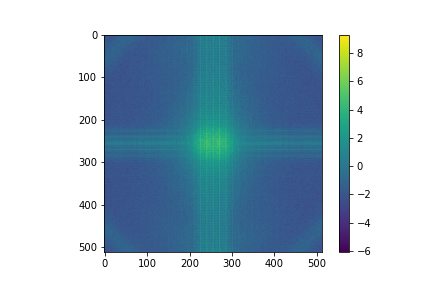

In [139]:
%matplotlib widget

y_shape, x_shape = np.shape(output_state)
XX, YY = np.meshgrid(np.linspace(0, x_shape, x_shape), np.linspace(0, y_shape, y_shape))

data_fft = fftshift(fft2(output_state))


plt.figure()
plt.imshow(np.log10(np.abs(data_fft)**2.0))
plt.colorbar()